In [1]:
# !pip install cloud-tpu-client==0.10 torch==2.0.0  torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/cuda/117/torch_xla-2.0-cp39-cp39-linux_x86_64.whl --force-reinstall

In [2]:
import sys
print(sys.version)



3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]


In [3]:
!nvidia-smi

Tue Feb 13 15:25:20 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:18:00.0 Off |                    0 |
| N/A   50C    P0    57W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   

In [4]:
import os
import PIL
from PIL import Image
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import time
# import torch_xla
# import torch_xla.core.xla_model as xm

torch.backends.cudnn.benchmark = True



In [5]:
# Utiliser CUDA si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

num_gpus = torch.cuda.device_count()
print(f"Nombre total de GPU disponibles : {num_gpus}")

# Affiche le nom de chaque GPU
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")



cuda
Nombre total de GPU disponibles : 2
GPU 0: Tesla V100-SXM2-32GB
GPU 1: Tesla V100-SXM2-32GB


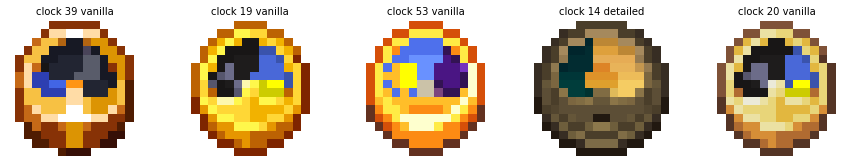

In [6]:
import pickle

# Charger le dataset
with open('only_clock.pkl', 'rb') as f:
    dataset = pickle.load(f)


def wrap_label(label, max_width=20):
    """
    Divise un label en plusieurs lignes si sa longueur dépasse max_width.
    """
    words = label.split()
    wrapped_label = ""
    line = ""
    for word in words:
        if len(line) + len(word) <= max_width:
            line += word + " "
        else:
            wrapped_label += line.strip() + "\n"
            line = word + " "
    wrapped_label += line.strip()
    return wrapped_label

# Example: print 5 random images on the same plot
fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # Adjust the figsize to change the overall plot size
for i, (image, label) in enumerate(random.sample(dataset, 5)):
    axes[i].imshow(image)
    axes[i].set_title(wrap_label(label), fontsize=10)  # Utilisez wrap_label pour diviser le label
    axes[i].axis('off')  # Remove the axis labels

# Adjust the spacing between the images
plt.subplots_adjust(wspace=0.3, hspace=0.6)  # Increase hspace to accommodate wrapped labels

# Show the plot
plt.show()

In [7]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer

class TextEmbedder(nn.Module):
    def __init__(self, embedding_dim, max_length):
        super(TextEmbedder, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
        self.embedding = nn.Embedding(self.tokenizer.vocab_size, embedding_dim)
        self.max_length = max_length

    def forward(self, text_list):
        # Tokenize et Tronquer/Rembourrer
        encoded_input = self.tokenizer(text_list, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt")
        token_ids = encoded_input['input_ids']

        # Embedding
        return self.embedding(token_ids)

# Créez une instance de la classe
embedding_dim = 40  # Dimension de l'espace d'embedding
max_length = 12     # Longueur maximale fixe (correspondant au max de mots dans le dataset)
text_embedder = TextEmbedder(embedding_dim, max_length)

# text_embedder.to(device)

for i, (image, label) in enumerate(random.sample(dataset, 5)):
    print(f"Label: {label}")
    print(f"Embedding: {text_embedder([label]).shape}")
    print()


Label: clock 06 coherent
Embedding: torch.Size([1, 12, 40])

Label: clock 58 coherent
Embedding: torch.Size([1, 12, 40])

Label: clock 02 sophisticated
Embedding: torch.Size([1, 12, 40])

Label: clock 07 stylized
Embedding: torch.Size([1, 12, 40])

Label: clock 57 enhanced
Embedding: torch.Size([1, 12, 40])



In [8]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, dataset, text_embedder):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5, 0.5])
        ])
        self.text_embedder = text_embedder

        self.transformed_images = []
        self.label_embeddings = []

        for image, label in dataset:
            self.transformed_images.append(self.transform(image))
            with torch.no_grad():
                embedded_label = self.text_embedder([label]).squeeze(0)
            self.label_embeddings.append(embedded_label.detach())

    def __len__(self):
        return len(self.transformed_images)

    def __getitem__(self, idx):
        return self.transformed_images[idx], self.label_embeddings[idx]

custom_dataset = CustomDataset(dataset, text_embedder)
dataloader = DataLoader(custom_dataset, batch_size=8, shuffle=True)

print(len(dataloader))


362


In [9]:
class Generator(nn.Module):
    def __init__(self, label_dim, img_channels, N_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(label_dim + N_dim, 4 * 4 * 1024),
            nn.Unflatten(1, (1024, 4, 4)),

            nn.InstanceNorm2d(1024, affine=False),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),

            # Bloc retiré

            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(256, img_channels, kernel_size=5, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, label):
        batch_size = label.size(0)
        # Génération du vecteur de bruit directement dans le forward
        noise = torch.randn(batch_size, N_dim, device=label.device)
        # Concaténation de l'étiquette et du bruit
        x = torch.cat((label, noise), dim=1)
        x = x.view(x.size(0), -1)
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, label_dim, img_channels):
        super(Discriminator, self).__init__()
        self.image_part = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),

            nn.Flatten(),

            # Nouvelles couches après l'aplatissement
            nn.Linear(128 * 4 * 4, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),

            nn.Linear(512, 128 * 4 * 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
        )
        self.label_part = nn.Linear(label_dim, 1024)
        self.combined_part = nn.Sequential(
            nn.Linear(128 * 4 * 4 + 1024, 1),
        )

    def forward(self, image, label_embedding):
        image_features = self.image_part(image)
        label_features = self.label_part(label_embedding.view(label_embedding.size(0), -1))
        combined = torch.cat([image_features, label_features], dim=1)
        return self.combined_part(combined)

# Initialisation des réseaux
label_dim = embedding_dim * max_length
img_channels = 4  # RGBA
N_dim = 50


generator = Generator(label_dim, img_channels, N_dim)
discriminator = Discriminator(label_dim, img_channels)

generator = nn.DataParallel(generator, device_ids=[0]) # Assurez-vous que ces IDs correspondent à vos GPU
discriminator = nn.DataParallel(discriminator, device_ids=[0])

discriminator.to(device)
generator.to(device)


DataParallel(
  (module): Generator(
    (net): Sequential(
      (0): Linear(in_features=530, out_features=16384, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(1024, 4, 4))
      (2): InstanceNorm2d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): LeakyReLU(negative_slope=0.01)
      (4): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): LeakyReLU(negative_slope=0.01)
      (10): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affin

## learning rate


In [10]:
# Utiliser RMSProp au lieu de Adam
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=0.0002)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=0.00025)

# Clipper les poids
def weights_clipper(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
        m.weight.data.clamp_(-0.01, 0.01)


In [11]:
# Fonction pour générer une image à partir d'un label
def generate_image(label, text_embedder, generator, device, noise_std=0.0001):
    # Transformer le label en embedding
    label_embedding = text_embedder([label]).squeeze(0).to(device)
    label_embedding = label_embedding.view(1, -1)

#     # Ajouter du bruit gaussien à l'embedding
#     noise = torch.randn_like(label_embedding) * noise_std
#     noisy_embedding = label_embedding + noise

    # Générer l'image
    with torch.no_grad():  # Pas besoin de calculer les gradients
        fake_image = generator(label_embedding).squeeze(0)

    return fake_image

def weights_init_normal(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

# # Appliquer l'initialisation
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)


# # load le modèle complet
# generator = torch.load('/content/drive/MyDrive/Colab Notebooks/deep learning/generator_model5.pth')
# discriminator = torch.load('/content/drive/MyDrive/Colab Notebooks/deep learning/discriminator_model5.pth')



DataParallel(
  (module): Discriminator(
    (image_part): Sequential(
      (0): Conv2d(4, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): LeakyReLU(negative_slope=0.2)
      (2): Dropout(p=0.3, inplace=False)
      (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (4): LeakyReLU(negative_slope=0.2)
      (5): Dropout(p=0.4, inplace=False)
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=2048, out_features=512, bias=True)
      (8): LeakyReLU(negative_slope=0.2)
      (9): Dropout(p=0.4, inplace=False)
      (10): Linear(in_features=512, out_features=2048, bias=True)
      (11): LeakyReLU(negative_slope=0.2)
      (12): Dropout(p=0.4, inplace=False)
    )
    (label_part): Linear(in_features=480, out_features=1024, bias=True)
    (combined_part): Sequential(
      (0): Linear(in_features=3072, out_features=1, bias=True)
    )
  )
)

clock 37 simplified
clock 45 vanilla
clock 05 detailed
clock 05 vanilla
clock 25 realistic


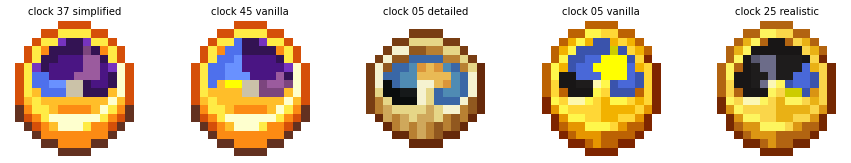

In [12]:

# import time
# time.sleep(10)


test_sample = random.sample(dataset, 5)

for image, label in test_sample:
  print(label)

# Example: print 5 random images on the same plot
fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # Adjust the figsize to change the overall plot size
for i, (image, label) in enumerate(test_sample):
    axes[i].imshow(image)
    axes[i].set_title(wrap_label(label), fontsize=10)  # Utilisez wrap_label pour diviser le label
    axes[i].axis('off')  # Remove the axis labels

# Adjust the spacing between the images
plt.subplots_adjust(wspace=0.3, hspace=0.6)  # Increase hspace to accommodate wrapped labels

# Show the plot
plt.show()

In [13]:
# Initialisation des listes pour enregistrer les pertes
d_losses = []
g_losses = []



Epoch 0
MSE entre images consécutives: 0.5055088400840759
MSE entre images consécutives: 0.6630337238311768
MSE entre images consécutives: 0.6712180376052856
MSE entre images consécutives: 0.21145275235176086


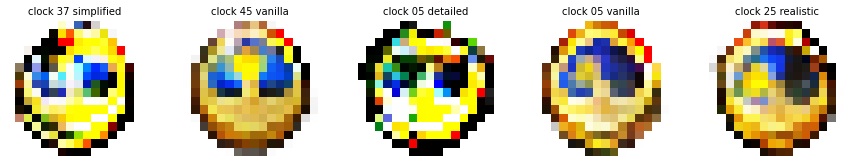

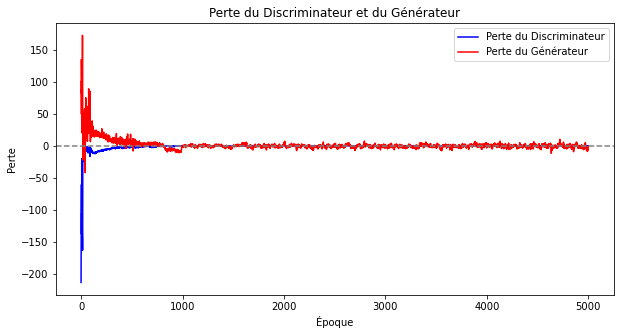

Epoch 10
MSE entre images consécutives: 0.761414647102356
MSE entre images consécutives: 0.7510977387428284
MSE entre images consécutives: 0.7287067770957947
MSE entre images consécutives: 0.2092152237892151


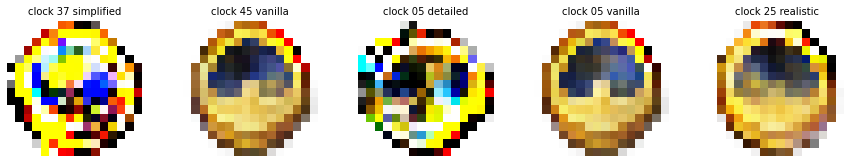

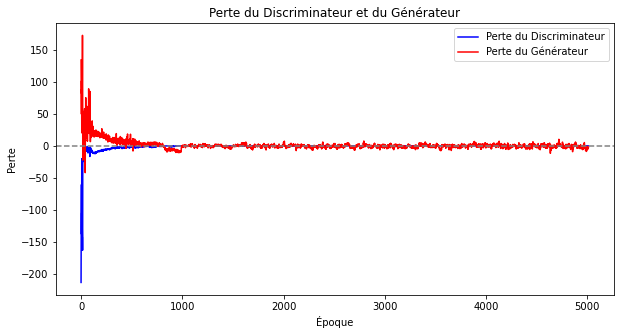

Epoch 20
MSE entre images consécutives: 0.5807095766067505
MSE entre images consécutives: 0.6630584001541138
MSE entre images consécutives: 0.685301661491394
MSE entre images consécutives: 0.2809281051158905


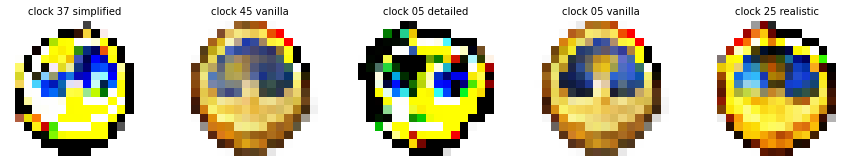

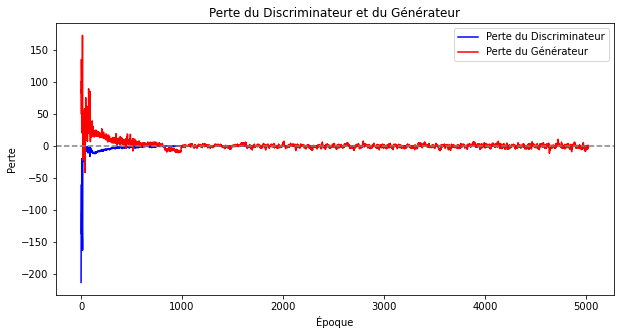

Epoch 30
MSE entre images consécutives: 0.5915963649749756
MSE entre images consécutives: 0.7809510231018066
MSE entre images consécutives: 0.7948864698410034
MSE entre images consécutives: 0.32538077235221863


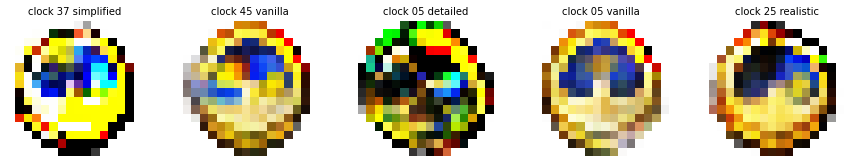

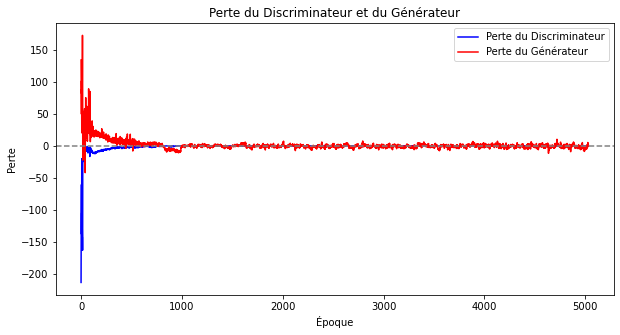

Epoch 40
MSE entre images consécutives: 0.37200719118118286
MSE entre images consécutives: 0.7081742286682129
MSE entre images consécutives: 0.6858762502670288
MSE entre images consécutives: 0.26311349868774414


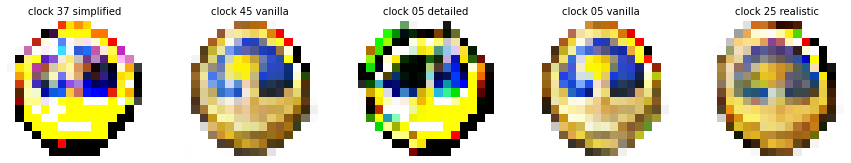

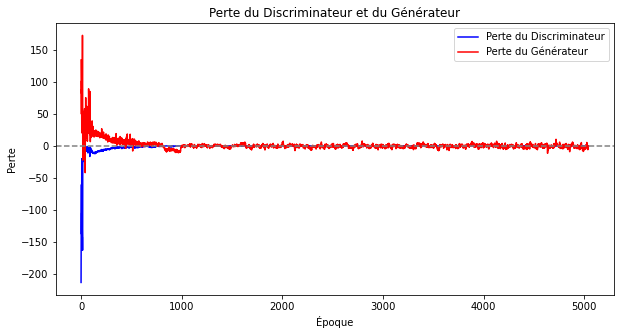

Epoch 50
MSE entre images consécutives: 0.5315782427787781
MSE entre images consécutives: 0.5075646638870239
MSE entre images consécutives: 0.5464308261871338
MSE entre images consécutives: 0.2791706621646881


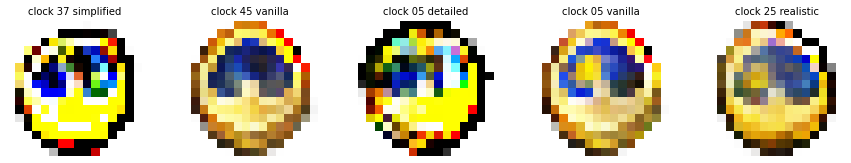

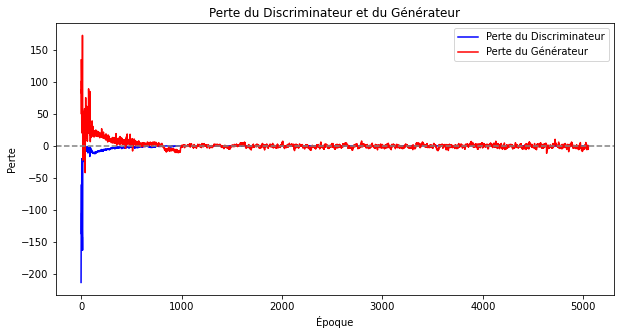

Epoch 60
MSE entre images consécutives: 0.5333688855171204
MSE entre images consécutives: 0.7688658237457275
MSE entre images consécutives: 0.7984448075294495
MSE entre images consécutives: 0.27693885564804077


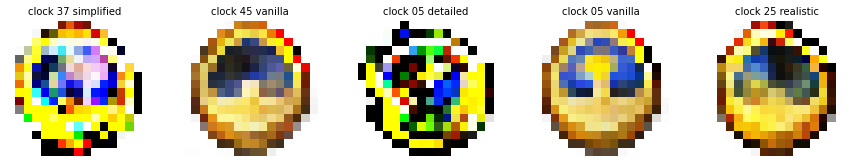

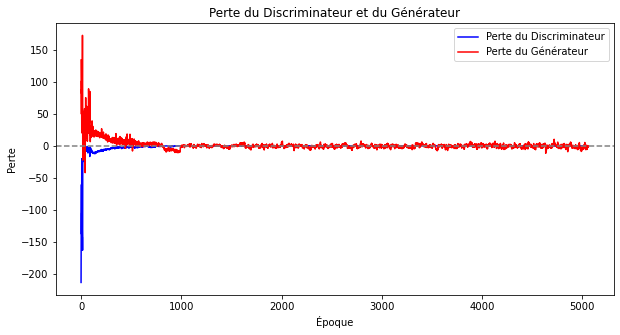

Epoch 70
MSE entre images consécutives: 0.7035408020019531
MSE entre images consécutives: 0.4899950623512268
MSE entre images consécutives: 0.5442429780960083
MSE entre images consécutives: 0.44577687978744507


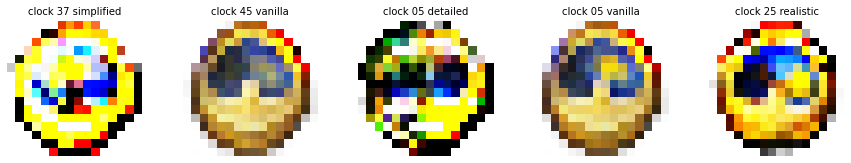

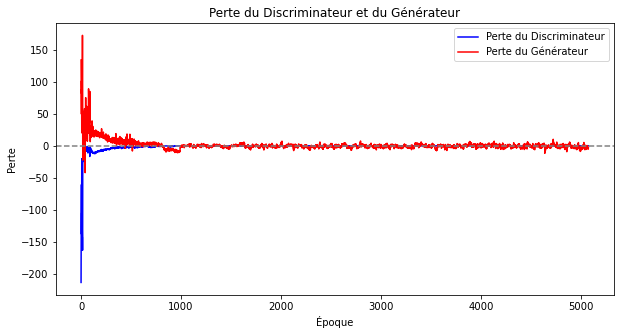

Epoch 80
MSE entre images consécutives: 0.46599018573760986
MSE entre images consécutives: 0.7814933061599731
MSE entre images consécutives: 0.8177126049995422
MSE entre images consécutives: 0.3123339116573334


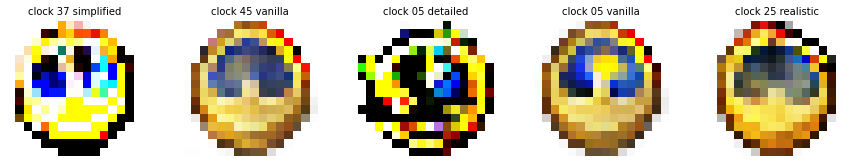

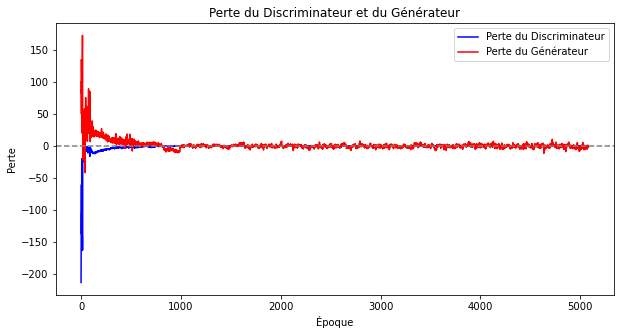

Epoch 90
MSE entre images consécutives: 0.48074084520339966
MSE entre images consécutives: 0.8408631086349487
MSE entre images consécutives: 0.8284287452697754
MSE entre images consécutives: 0.34925615787506104


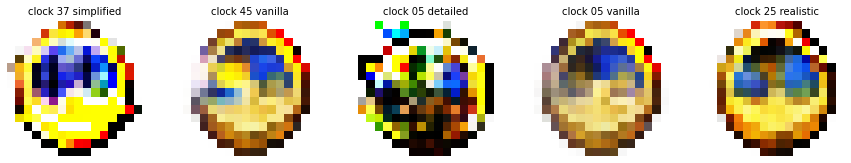

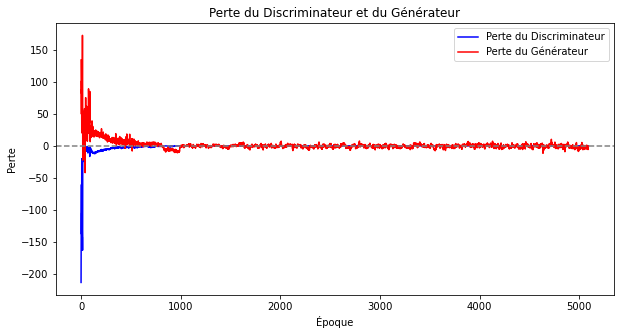

Epoch 100
MSE entre images consécutives: 0.4914695620536804
MSE entre images consécutives: 0.7493641376495361
MSE entre images consécutives: 0.7067046165466309
MSE entre images consécutives: 0.3305438756942749


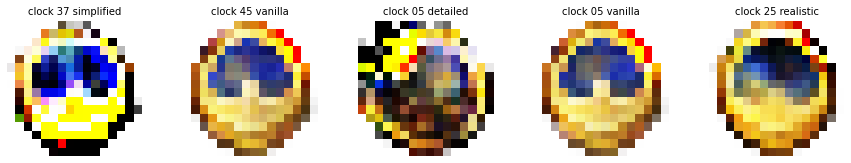

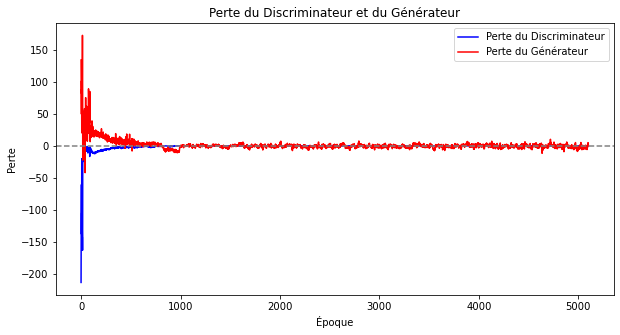

Epoch 110
MSE entre images consécutives: 0.5816777944564819
MSE entre images consécutives: 0.7731014490127563
MSE entre images consécutives: 0.7674851417541504
MSE entre images consécutives: 0.28169676661491394


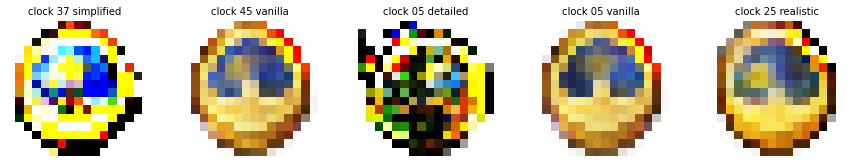

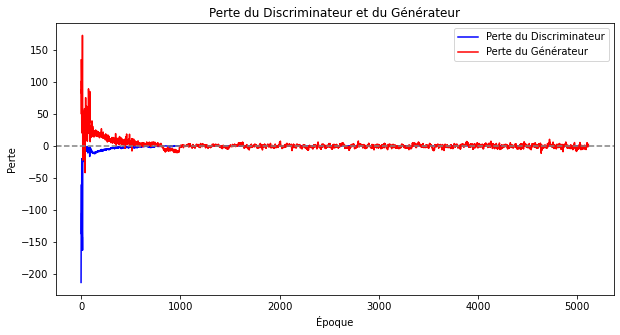

Epoch 120
MSE entre images consécutives: 0.31913506984710693
MSE entre images consécutives: 0.5727579593658447
MSE entre images consécutives: 0.5336562395095825
MSE entre images consécutives: 0.3462001085281372


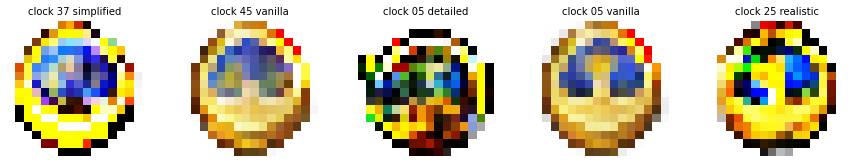

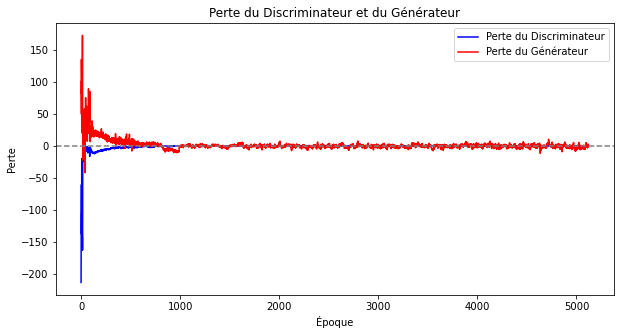

Epoch 130
MSE entre images consécutives: 0.4645615816116333
MSE entre images consécutives: 0.6246337890625
MSE entre images consécutives: 0.6779612302780151
MSE entre images consécutives: 0.23961031436920166


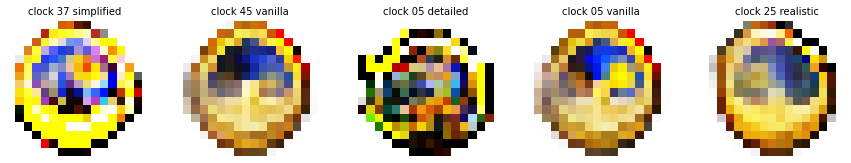

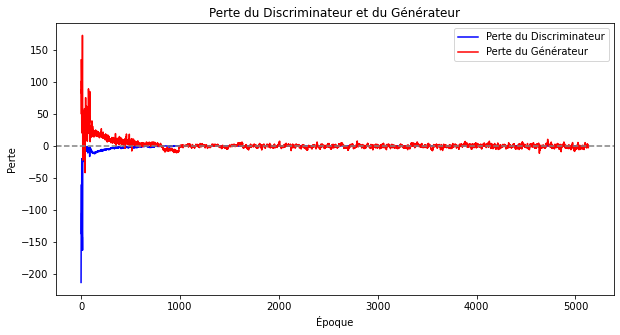

Epoch 140
MSE entre images consécutives: 0.6097970604896545
MSE entre images consécutives: 0.7835655212402344
MSE entre images consécutives: 0.846958577632904
MSE entre images consécutives: 0.2815816402435303


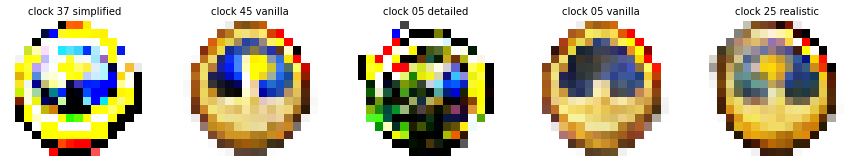

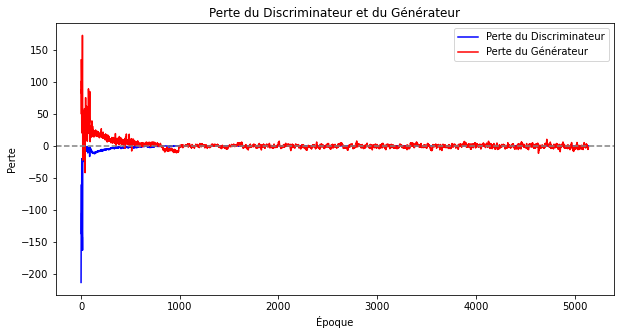

Epoch 150
MSE entre images consécutives: 0.6374533772468567
MSE entre images consécutives: 0.8375890851020813
MSE entre images consécutives: 0.6431479454040527
MSE entre images consécutives: 0.3536583185195923


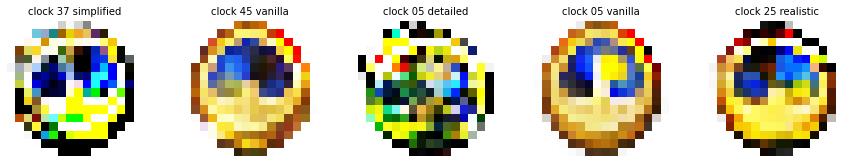

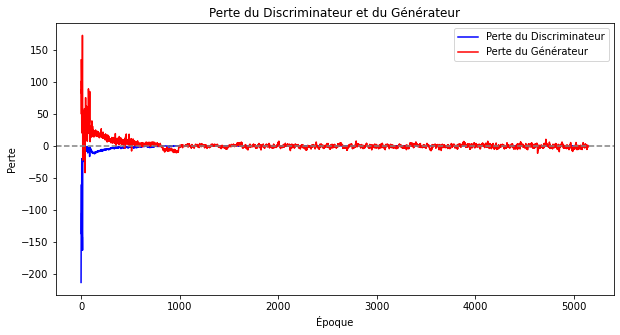

Epoch 160
MSE entre images consécutives: 0.46754443645477295
MSE entre images consécutives: 0.687807023525238
MSE entre images consécutives: 0.7117624282836914
MSE entre images consécutives: 0.2283180058002472


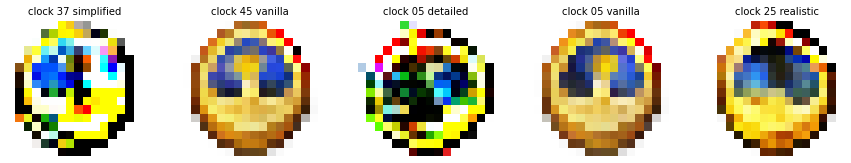

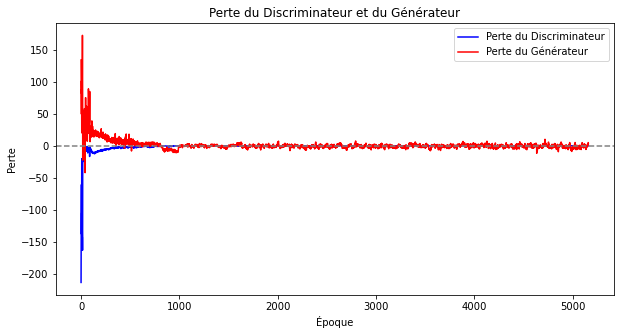

Epoch 170
MSE entre images consécutives: 0.3982830047607422
MSE entre images consécutives: 0.7741859555244446
MSE entre images consécutives: 0.868070125579834
MSE entre images consécutives: 0.2513754367828369


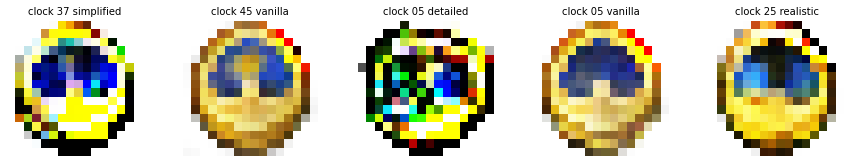

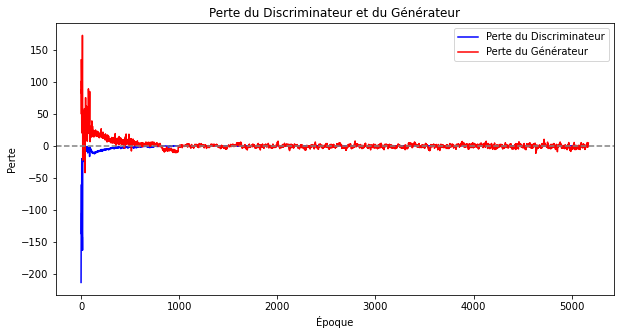

Epoch 180
MSE entre images consécutives: 0.6271770596504211
MSE entre images consécutives: 0.7262017130851746
MSE entre images consécutives: 0.6807762384414673
MSE entre images consécutives: 0.2243877649307251


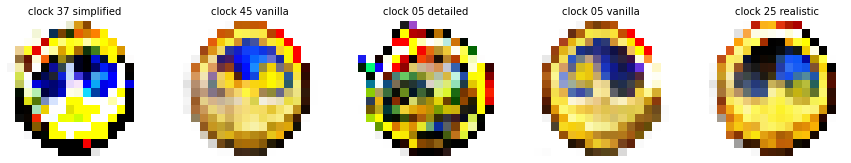

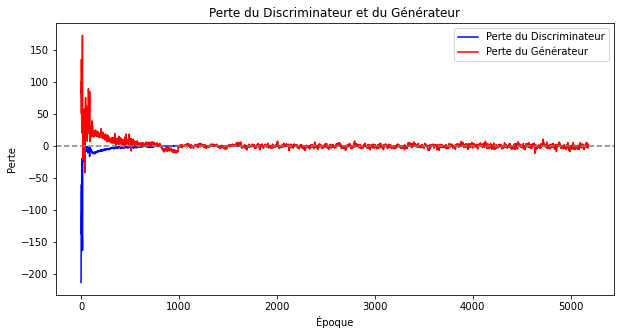

Epoch 190
MSE entre images consécutives: 0.5930447578430176
MSE entre images consécutives: 0.8110678195953369
MSE entre images consécutives: 0.6570848226547241
MSE entre images consécutives: 0.25024476647377014


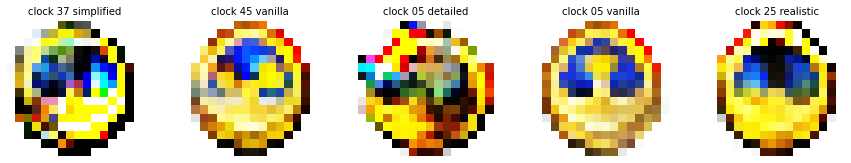

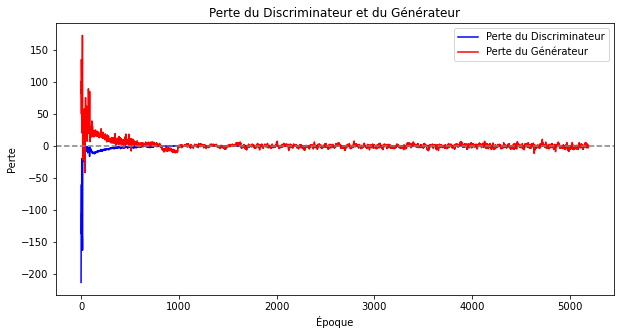

Epoch 200
MSE entre images consécutives: 0.4023440182209015
MSE entre images consécutives: 0.6596125364303589
MSE entre images consécutives: 0.6425633430480957
MSE entre images consécutives: 0.23090165853500366


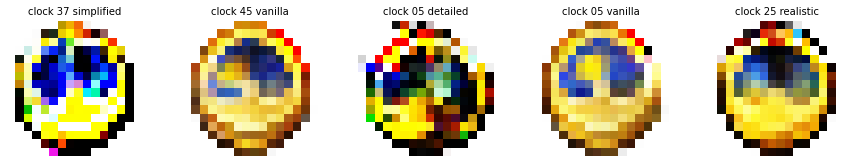

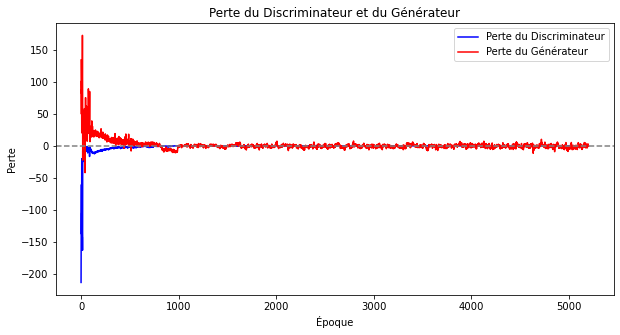

Epoch 210
MSE entre images consécutives: 0.3474428057670593
MSE entre images consécutives: 0.7353526949882507
MSE entre images consécutives: 0.9331438541412354
MSE entre images consécutives: 0.43709009885787964


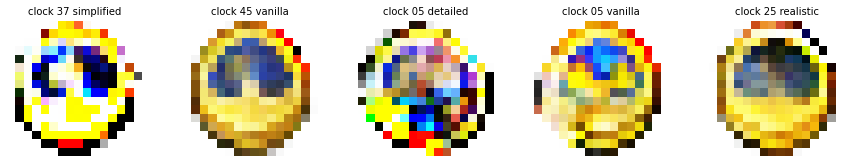

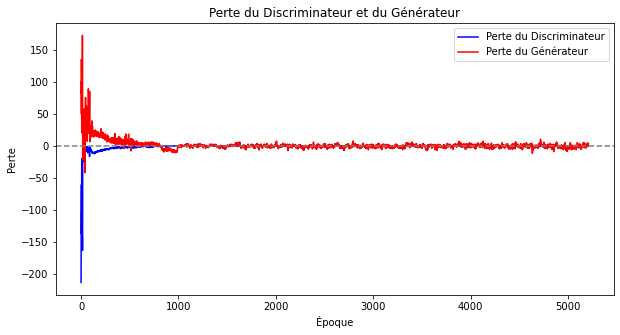

Epoch 220
MSE entre images consécutives: 0.2806192636489868
MSE entre images consécutives: 0.8202747702598572
MSE entre images consécutives: 0.8433755040168762
MSE entre images consécutives: 0.31435248255729675


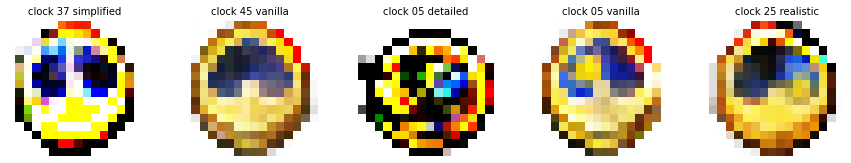

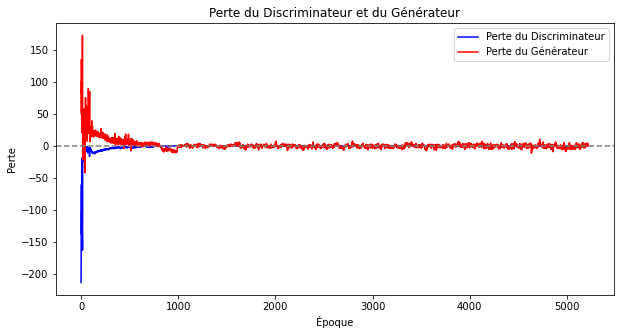

Epoch 230
MSE entre images consécutives: 0.5127112865447998
MSE entre images consécutives: 0.7080483436584473
MSE entre images consécutives: 0.7076718807220459
MSE entre images consécutives: 0.2019902765750885


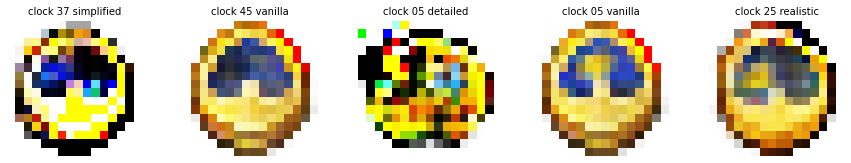

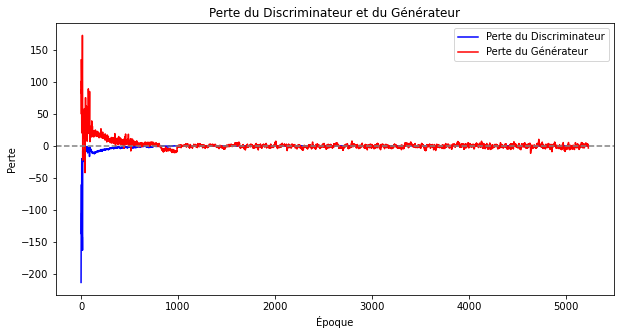

Epoch 240
MSE entre images consécutives: 0.5766474008560181
MSE entre images consécutives: 0.545325756072998
MSE entre images consécutives: 0.47134754061698914
MSE entre images consécutives: 0.2770389914512634


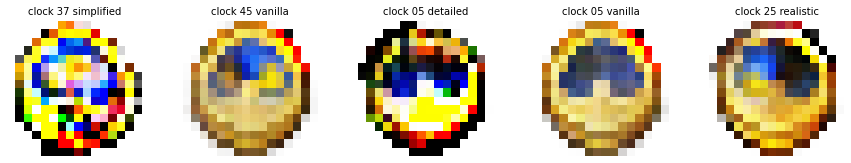

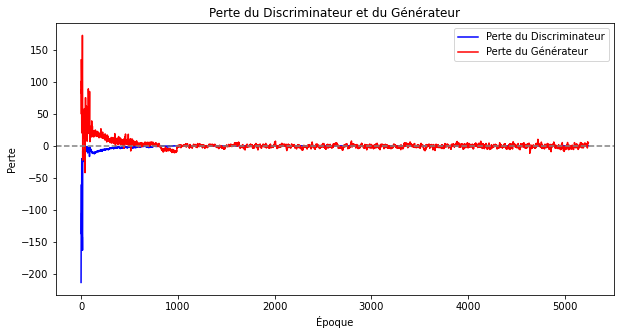

Epoch 250
MSE entre images consécutives: 0.4375486373901367
MSE entre images consécutives: 0.8119343519210815
MSE entre images consécutives: 0.7692009806632996
MSE entre images consécutives: 0.18457408249378204


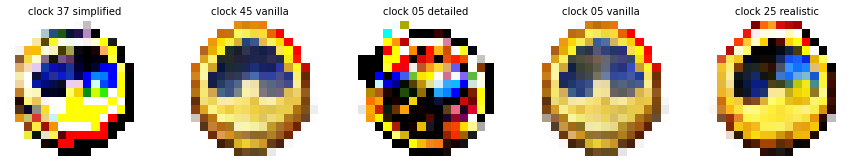

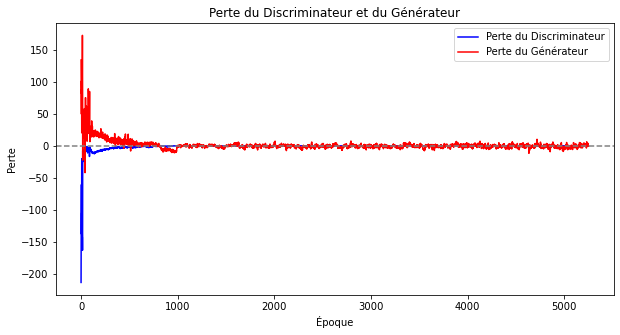

Epoch 260
MSE entre images consécutives: 0.3586769104003906
MSE entre images consécutives: 0.6667951345443726
MSE entre images consécutives: 0.6489181518554688
MSE entre images consécutives: 0.331392765045166


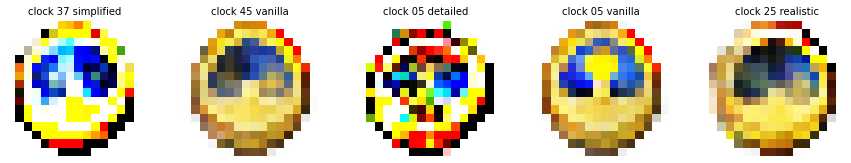

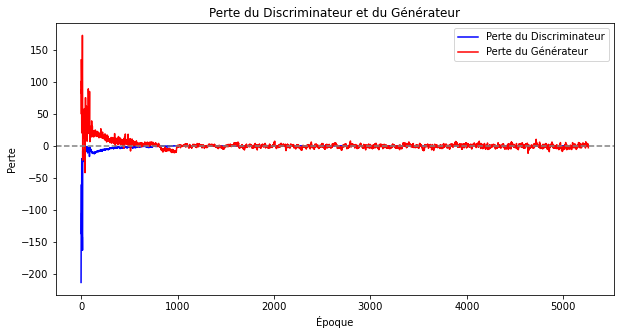

Epoch 270
MSE entre images consécutives: 0.43140149116516113
MSE entre images consécutives: 0.6956876516342163
MSE entre images consécutives: 0.6160063743591309
MSE entre images consécutives: 0.26618242263793945


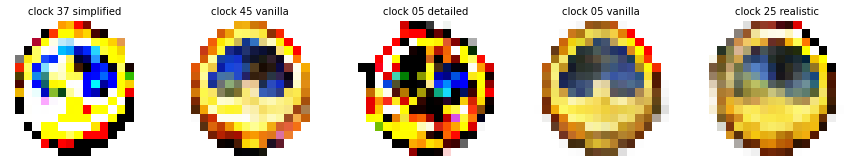

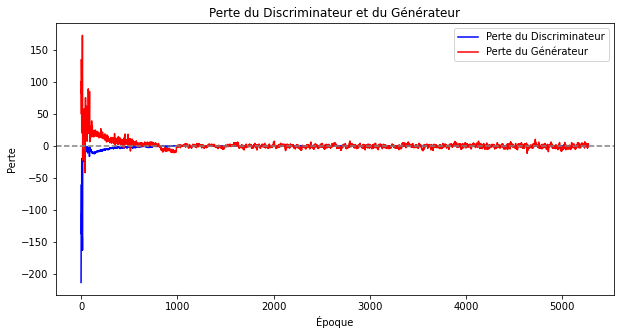

Epoch 280
MSE entre images consécutives: 0.6539098024368286
MSE entre images consécutives: 0.5321744680404663
MSE entre images consécutives: 0.4748735725879669
MSE entre images consécutives: 0.18824943900108337


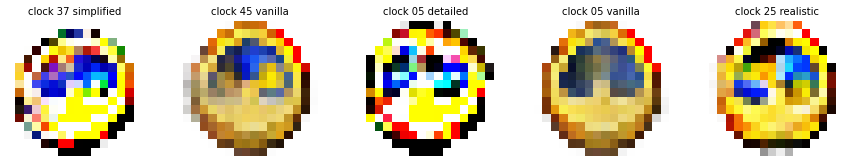

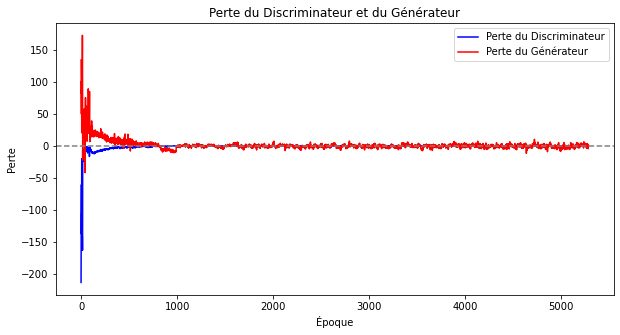

Epoch 290
MSE entre images consécutives: 0.33818960189819336
MSE entre images consécutives: 0.5687462687492371
MSE entre images consécutives: 0.5965255498886108
MSE entre images consécutives: 0.14625850319862366


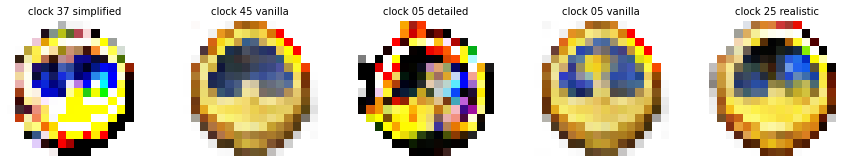

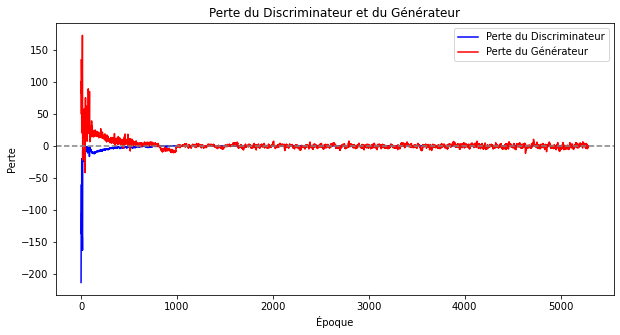

Epoch 300
MSE entre images consécutives: 0.5595360994338989
MSE entre images consécutives: 0.7131437063217163
MSE entre images consécutives: 0.5347403287887573
MSE entre images consécutives: 0.2743607759475708


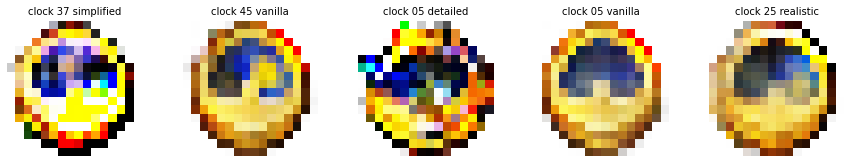

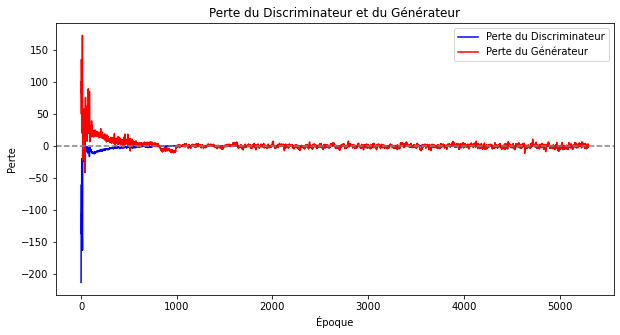

Epoch 310
MSE entre images consécutives: 0.49553030729293823
MSE entre images consécutives: 0.7743781805038452
MSE entre images consécutives: 0.8019769191741943
MSE entre images consécutives: 0.23588788509368896


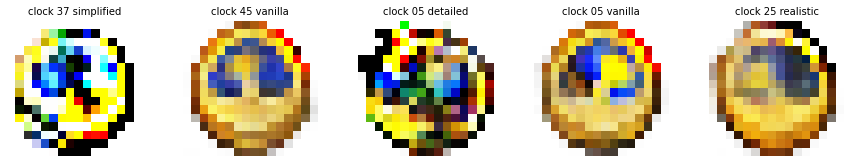

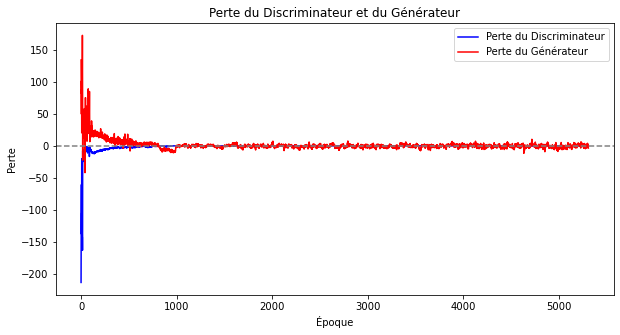

Epoch 320
MSE entre images consécutives: 0.43846970796585083
MSE entre images consécutives: 0.45202165842056274
MSE entre images consécutives: 0.4955800771713257
MSE entre images consécutives: 0.29201751947402954


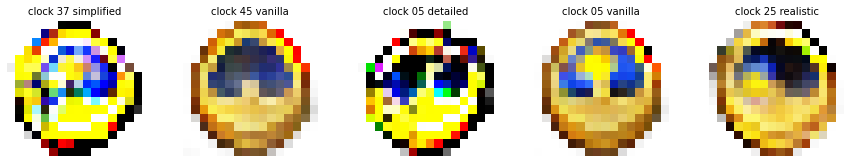

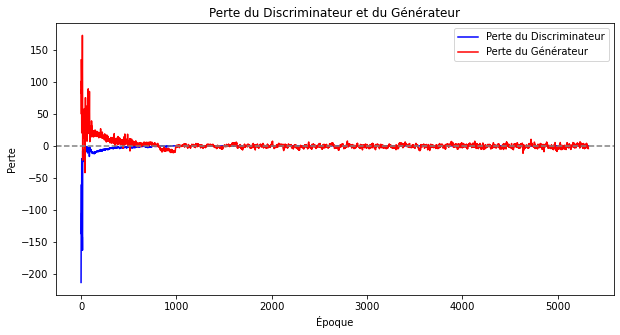

Epoch 330
MSE entre images consécutives: 0.39450180530548096
MSE entre images consécutives: 0.7809097766876221
MSE entre images consécutives: 0.7889142036437988
MSE entre images consécutives: 0.20275241136550903


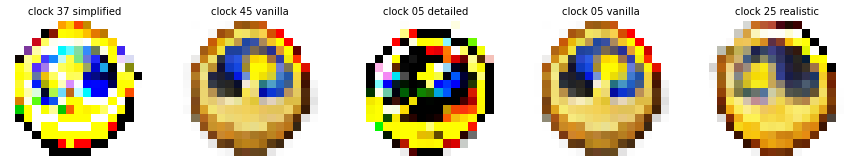

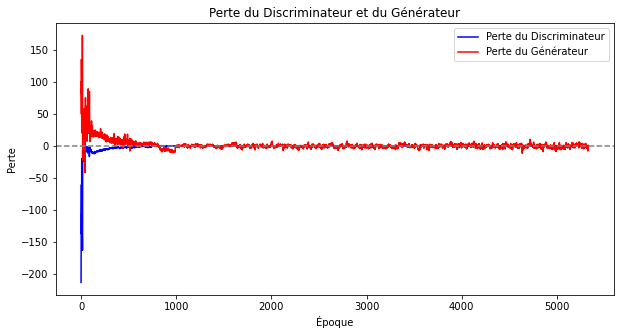

Epoch 340
MSE entre images consécutives: 0.3899575471878052
MSE entre images consécutives: 0.910367488861084
MSE entre images consécutives: 0.8496270775794983
MSE entre images consécutives: 0.2128215730190277


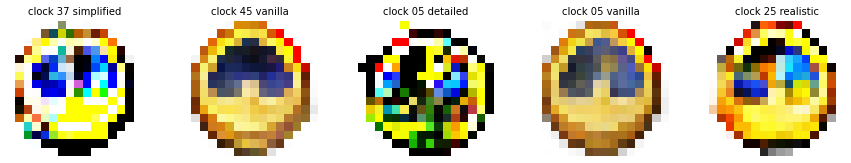

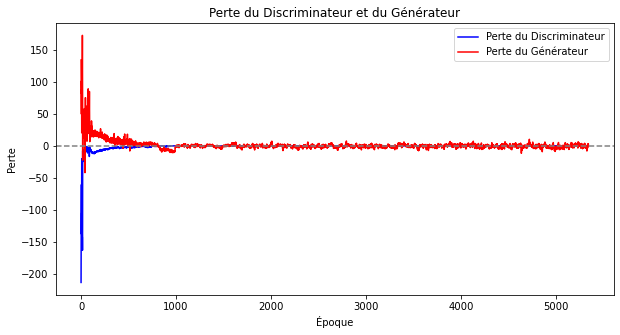

Epoch 350
MSE entre images consécutives: 0.5347603559494019
MSE entre images consécutives: 0.8506335020065308
MSE entre images consécutives: 0.7367088794708252
MSE entre images consécutives: 0.13670706748962402


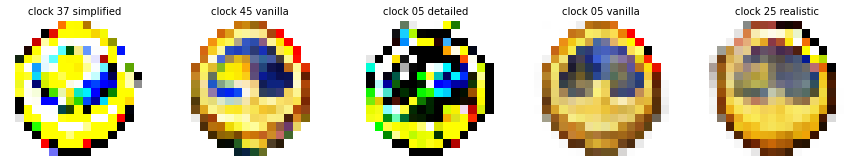

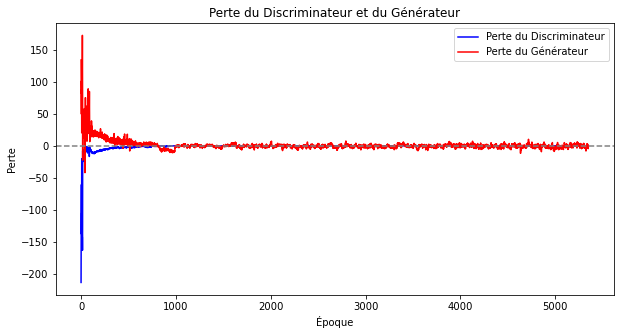

Epoch 360
MSE entre images consécutives: 0.5023109912872314
MSE entre images consécutives: 0.8020504117012024
MSE entre images consécutives: 0.7961146831512451
MSE entre images consécutives: 0.1541656255722046


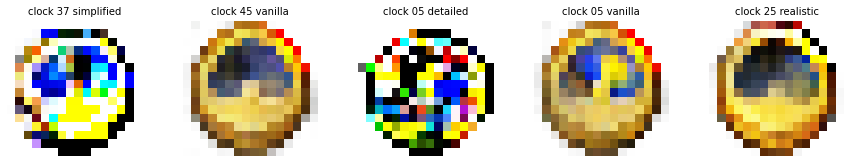

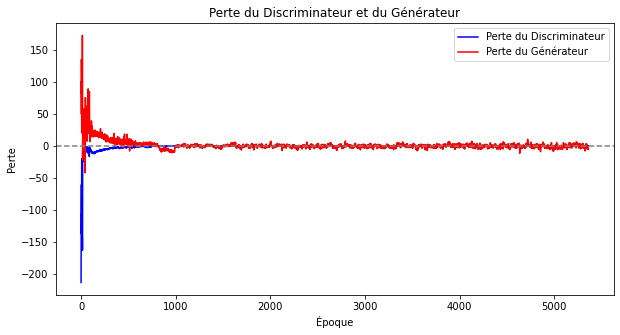

Epoch 370
MSE entre images consécutives: 0.49966150522232056
MSE entre images consécutives: 0.9054738283157349
MSE entre images consécutives: 0.8906301856040955
MSE entre images consécutives: 0.4138708710670471


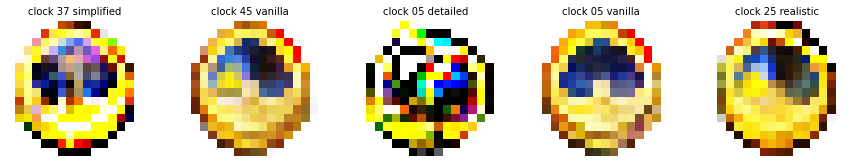

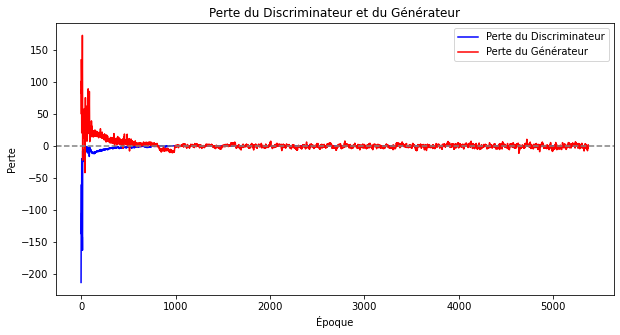

Epoch 380
MSE entre images consécutives: 0.5118125081062317
MSE entre images consécutives: 0.6040878295898438
MSE entre images consécutives: 0.6445986032485962
MSE entre images consécutives: 0.23431026935577393


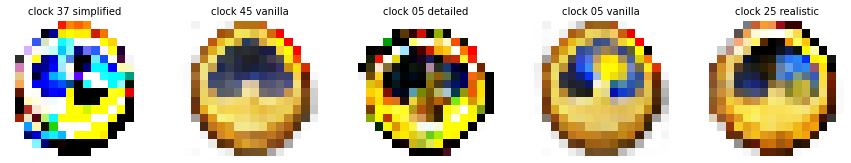

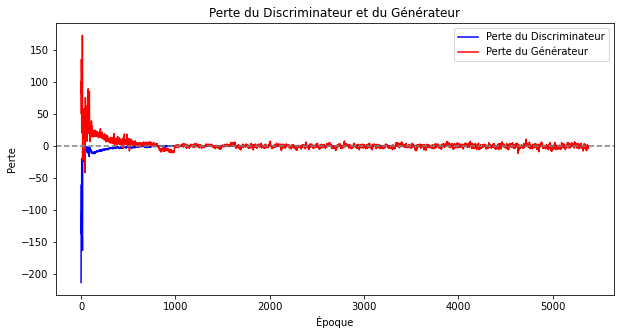

Epoch 390
MSE entre images consécutives: 0.5017961859703064
MSE entre images consécutives: 0.8340197801589966
MSE entre images consécutives: 0.9659289717674255
MSE entre images consécutives: 0.34675878286361694


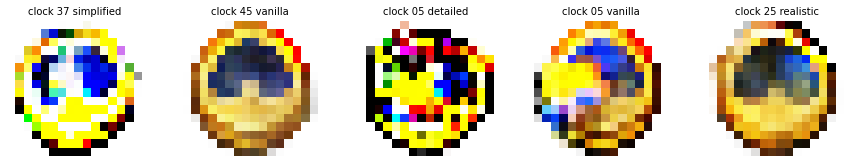

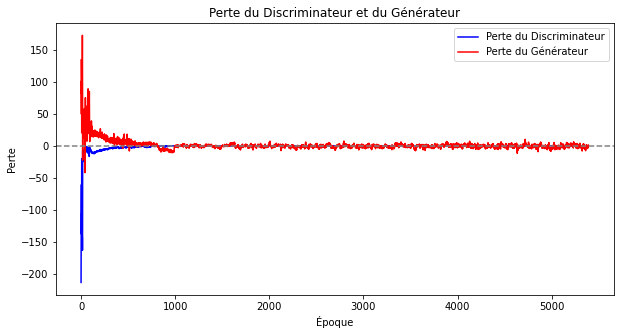

Epoch 400
MSE entre images consécutives: 0.4399999976158142
MSE entre images consécutives: 0.7883763313293457
MSE entre images consécutives: 0.8278504610061646
MSE entre images consécutives: 0.3036075830459595


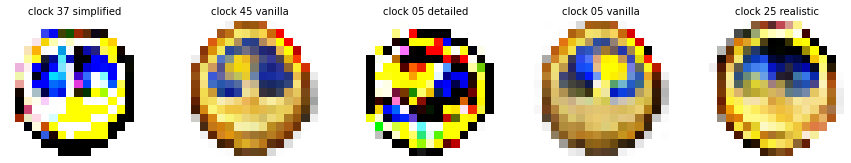

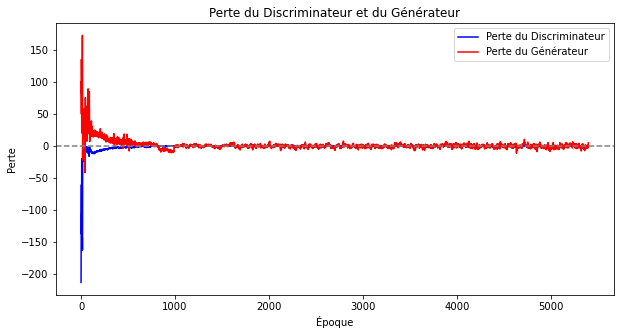

Epoch 410
MSE entre images consécutives: 0.5835860371589661
MSE entre images consécutives: 0.7017064690589905
MSE entre images consécutives: 0.731891393661499
MSE entre images consécutives: 0.1880713701248169


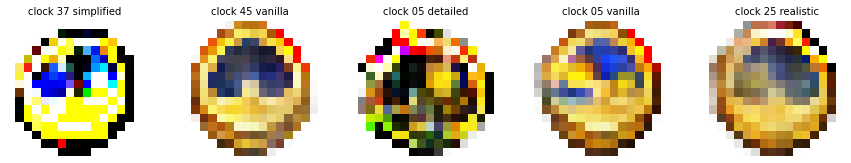

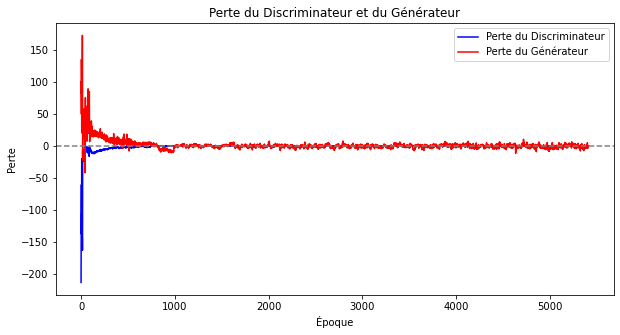

KeyboardInterrupt: 

In [17]:
import time
from torch.nn.functional import mse_loss



# Boucle d'entraînement
num_epochs = 500
num_saves = 5

update_generator_every_n_steps = 5  # Met à jour le discriminateur une fois sur deux


def add_gaussian_noise(vector, sigma=0.0001):
    """
    Ajoute un bruit gaussien aux vecteur.
    :param vector: Un batch de vecteur d'image ou de label.
    :param sigma: Écart-type du bruit gaussien.
    :return: Images bruitées.
    """
    noise = torch.randn_like(vector) * sigma
    return vector + noise



for num_save in range(num_saves):
    for epoch in range(num_epochs):
        start_time = time.time()  # Début du chronométrage pour cette époque
        d_loss_epoch = 0
        g_loss_epoch = 0
        num_batches = 0

        if epoch % 10 == 0:
            print(f"Epoch {epoch}")
            fig, axes = plt.subplots(1, 5, figsize=(15, 3))
            previous_image = None
            for i, (image, label) in enumerate(test_sample):
                generated_image = generate_image(label, text_embedder, generator, device)

                # Calcul de la MSE si ce n'est pas la première image
                if previous_image is not None:
                    mse_value = mse_loss(generated_image, previous_image)
                    print(f"MSE entre images consécutives: {mse_value.item()}")

                # Stocker l'image actuelle pour la comparer à la suivante
                previous_image = generated_image

                mean = torch.tensor([0.5, 0.5, 0.5, 0.5]).view(4, 1, 1).to(device)
                std = torch.tensor([0.5, 0.5, 0.5, 0.5]).view(4, 1, 1).to(device)
                generated_image = generated_image * std + mean
                generated_image = generated_image.permute(1, 2, 0).cpu().numpy()
                axes[i].imshow(generated_image[..., :4], alpha=generated_image[..., 3])
                axes[i].set_title(wrap_label(label), fontsize=10)
                axes[i].axis('off')


            plt.subplots_adjust(wspace=0.3, hspace=0.6)
            plt.show()

        
        for i, (images, labels) in enumerate(dataloader):
            # Mise à jour du discriminateur
            optimizer_D.zero_grad()

            # Entraînement avec de vraies images
            real_images = images.to(device)
            real_labels = labels.to(device).view(labels.size(0), -1)
#             print(real_labels.shape)
#             real_labels = add_gaussian_noise(real_labels)
            
            outputs_real = discriminator(real_images, real_labels).mean()

            # Entraînement avec de fausses images
            fake_images = generator(real_labels).detach()
            outputs_fake = discriminator(fake_images, real_labels).mean()

            # Calculer la perte du discriminateur et mise à jour
            d_loss = outputs_fake - outputs_real
            d_loss.backward()
            optimizer_D.step()

            # Clipper les poids du discriminateur
            discriminator.apply(weights_clipper)

            # Mise à jour du générateur toutes les N étapes
            if i % update_generator_every_n_steps == 0:
                optimizer_G.zero_grad()

                # Générer des fausses images
                fake_images = generator(real_labels)
                outputs = discriminator(fake_images, real_labels).mean()

                # Calculer la perte du générateur et mise à jour
                g_loss = -outputs
                g_loss.backward()
                optimizer_G.step()

            d_loss_epoch += d_loss.item()
            g_loss_epoch += g_loss.item()
            num_batches += 1
            
            
#             if (i+1) % 100 == 0:
#                 print(f'Epoch [{num_save}:{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

        d_losses.append(d_loss_epoch / num_batches)
        g_losses.append(g_loss_epoch / num_batches)

        if epoch % 10 == 0:
            # Affichage des courbes de perte sur un seul graphique
            plt.figure(figsize=(10, 5))
            plt.plot(d_losses, label='Perte du Discriminateur', color='blue')
            plt.plot(g_losses, label='Perte du Générateur', color='red')
            plt.title('Perte du Discriminateur et du Générateur')
            plt.xlabel('Époque')
            plt.ylabel('Perte')
            plt.axhline(y=0, color='gray', linestyle='--')
            plt.legend()
            plt.show()

        epoch_duration = time.time() - start_time
#         print(f"Durée de l'époque {num_save}:{epoch + 1}: {epoch_duration:.2f} secondes")

    # Enregistrer le modèle complet
    torch.save(generator, f'models_step/generator_model_2_{num_save}.pth')
    torch.save(discriminator, f'models_step/discriminator_model_2_{num_save}.pth')

print('Entraînement terminé.')

In [15]:
# Enregistrer le modèle complet
torch.save(generator, '/content/drive/MyDrive/Colab Notebooks/deep learning/generator_model6.pth')
torch.save(discriminator, '/content/drive/MyDrive/Colab Notebooks/deep learning/discriminator_model6.pth')


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/deep learning/generator_model6.pth'

In [ ]:
import torch
import matplotlib.pyplot as plt

# Création d'une grille de 5x5 pour les sous-graphiques
fig, axes = plt.subplots(1, 1, figsize=(15, 15))  # Ajustez figsize selon vos besoins
axes = axes.flatten()  # Aplatir le tableau d'axes pour un accès facile dans la boucle

for i in range(1):
    label = f"vanilla minecraft grass block"
    # Génération d'une image
    generated_image = generate_image(label, text_token_embedder, generator, device)

    # Dénormalisation et préparation pour l'affichage
    mean = torch.tensor([0.5, 0.5, 0.5, 0.5]).view(4, 1, 1).to(device)
    std = torch.tensor([0.5, 0.5, 0.5, 0.5]).view(4, 1, 1).to(device)
    generated_image = generated_image * std + mean
    generated_image = generated_image.permute(1, 2, 0).cpu().numpy()

    # Affichage de l'image
    axes[i].imshow(generated_image[..., :3], alpha=generated_image[..., 3])
    axes[i].set_title(label)
    axes[i].axis('off')  # Supprimer les étiquettes des axes

# Ajustement de l'espacement entre les images
plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Ajustez ces valeurs pour modifier l'espacement

plt.show()